In [1]:
import sys
import argparse
import os
import gc
import pandas as pd
import numpy as np
import random
from math import floor, ceil

import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


import torch
from torchvision import datasets, models, transforms

import albumentations
from albumentations import pytorch as AT
from Augmentation import *

from DataSampler import *

In [2]:
data_path = "/media/jionie/my_disk/Kaggle/Bengaliai/input/bengaliai-cv19/"
image_df = pd.read_parquet(os.path.join(data_path, f'train_image_data_0.parquet'))

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 137, 236
IMAGE_HEIGHT_RESIZE, IMAGE_WIDTH_RESIZE = 224, 224

In [4]:
train_transform = albumentations.Compose([
    CropCharImage(threshold=15, p=0.5),
    albumentations.Resize(IMAGE_HEIGHT_RESIZE, IMAGE_WIDTH_RESIZE),
    albumentations.Rotate(limit=20, p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=5, p=0.5),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5, p=1.0),
        albumentations.Blur(blur_limit=5, p=1.0),
        albumentations.GaussianBlur(blur_limit=5, p=1.0)
    ], p=0.5), 
    albumentations.GridDistortion(distort_limit=0.1, p=0.5), 
    ])


test_transform = albumentations.Compose([
    albumentations.Resize(IMAGE_HEIGHT_RESIZE, IMAGE_WIDTH_RESIZE),
    ])

In [5]:
image = image_df.loc[image_df['image_id']=="Train_0", image_df.columns[1:]].values.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype('uint8')
image = augment_and_mix(image, severity=1, width=1, depth=-1, alpha=1.)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [6]:
image = train_transform(image=image)['image']

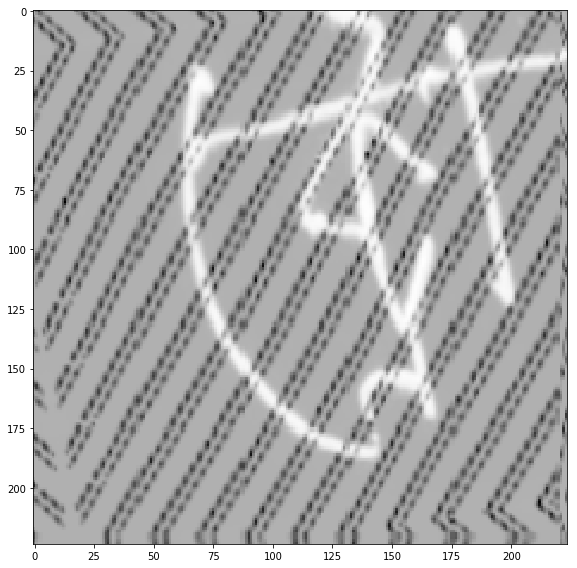

<Figure size 432x288 with 0 Axes>

In [7]:
# val_transform
nrow, ncol = 1, 1
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))
ax.imshow(image, cmap='Greys')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

In [8]:
class bengaliai_Dataset(torch.utils.data.Dataset):
    def __init__(self, \
                data_path, \
                df, \
                labeled=True, \
                transform = transforms.Compose([transforms.RandomResizedCrop(128),transforms.ToTensor()]), \
                grapheme_root_labels_dict={}, \
                vowel_diacritic_labels_dict={}, \
                consonant_diacritic_labels_dict={}, \
                grapheme_labels_dict={}):

        self.data_path = data_path
        self.df = df
        self.labeled = labeled
        self.transform = transform
        self.image_df = pd.concat([pd.read_parquet(os.path.join(data_path, f'train_image_data_{i}.parquet')) for i in range(4)]).reindex()
        self.image_df.iloc[:, 1:] = self.image_df.iloc[:, 1:].astype(np.uint8)
        if self.labeled:
            self.uid = self.df['image_id'].values
        else:
            # we don't need to spilt
            self.uid = self.image_df['image_id'].values
        # self.image = self.image_df.drop('image_id', axis=1).values.astype(np.uint8)
    
        self.grapheme_root_labels_dict = grapheme_root_labels_dict
        self.vowel_diacritic_labels_dict = vowel_diacritic_labels_dict
        self.consonant_diacritic_labels_dict = consonant_diacritic_labels_dict
        self.grapheme_labels_dict = grapheme_labels_dict
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        image_id = self.uid[idx]
        # image = self.image[idx].copy().reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        image = \
            self.image_df.loc[self.image_df["image_id"] == image_id, self.image_df.columns[1:]].values.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        
        if np.random.uniform() < 0.5:
            image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype('uint8')
            image = augment_and_mix(image, severity=1, width=1, depth=-1, alpha=1.)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if not (self.transform is None):
            image = self.transform(image=np.float32(image))['image']
            
        image = np.repeat(np.expand_dims(image, axis=0), 3, axis=0).astype(np.float32)
        image = image / 255
        
        if self.labeled:
            
            return image, \
                self.grapheme_root_labels_dict[image_id], \
                self.vowel_diacritic_labels_dict[image_id], \
                self.consonant_diacritic_labels_dict[image_id], \
                self.grapheme_labels_dict[image_id]
        else:
            return image

In [9]:
def get_train_val_dataset(data_path="/media/jionie/my_disk/Kaggle/Bengaliai/input/bengaliai-cv19/", \
                        train_df="/media/jionie/my_disk/Kaggle/Bengaliai/input/bengaliai-cv19/split/MultilabelStratifiedKFold/train_fold_0_seed_12.csv", \
                        val_data_path="/media/jionie/my_disk/Kaggle/Bengaliai/input/bengaliai-cv19/", \
                        val_df="/media/jionie/my_disk/Kaggle/Bengaliai/input/bengaliai-cv19/split/MultilabelStratifiedKFold/val_fold_0_seed_12.csv", \
                        batch_size=4, \
                        val_batch_size=4, \
                        num_workers=2, \
                        train_transform=None, \
                        val_transform=None, \
                        Balanced="ImbalancedDatasetSampler"):
    

    
    train_df = pd.read_csv(train_df, encoding='utf8')
    val_df = pd.read_csv(val_df, encoding='utf8')
    df = pd.concat([train_df, val_df], axis=0)
    
    print(train_df.shape)
    print(val_df.shape)
    
    # print(train_df.columns)
    
    def prepare_labels(y):
        values = np.array(y)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        onehot_encoded = onehot_encoder.fit_transform(values.reshape(values.shape[0], 1))
        y = onehot_encoded
        return y
    
    class_map = dict(pd.read_csv(data_path + '/grapheme_1295.csv')[['grapheme','label']].values)
    train_df['grapheme'] = train_df['grapheme'].map(class_map)
    val_df['grapheme'] = val_df['grapheme'].map(class_map)
    df['grapheme'] = df['grapheme'].map(class_map)
    
    labels_encoded_grapheme_root = prepare_labels(df['grapheme_root'].values)
    img_class_dict_grapheme_root = {k:v for k, v in zip(df['image_id'].values, labels_encoded_grapheme_root)}
    
    labels_encoded_vowel_diacritic = prepare_labels(df['vowel_diacritic'].values)
    img_class_dict_vowel_diacritic = {k:v for k, v in zip(df['image_id'].values, labels_encoded_vowel_diacritic)}
    
    labels_encoded_consonant_diacritic = prepare_labels(df['consonant_diacritic'].values)
    img_class_dict_consonant_diacritic = {k:v for k, v in zip(df['image_id'].values, labels_encoded_consonant_diacritic)}
    
    labels_encoded_grapheme = prepare_labels(df['grapheme'].values)
    img_class_dict_grapheme = {k:v for k, v in zip(df['image_id'].values, labels_encoded_grapheme)}
    
    ds_train = bengaliai_Dataset(data_path, \
                                train_df, \
                                labeled=True, \
                                transform=train_transform, \
                                grapheme_root_labels_dict=img_class_dict_grapheme_root, \
                                vowel_diacritic_labels_dict=img_class_dict_vowel_diacritic, \
                                consonant_diacritic_labels_dict=img_class_dict_consonant_diacritic, \
                                grapheme_labels_dict=img_class_dict_grapheme)

    ds_val = bengaliai_Dataset(data_path, \
                               val_df, \
                               labeled=True, \
                               transform=val_transform, \
                               grapheme_root_labels_dict=img_class_dict_grapheme_root, \
                               vowel_diacritic_labels_dict=img_class_dict_vowel_diacritic, \
                               consonant_diacritic_labels_dict=img_class_dict_consonant_diacritic, \
                               grapheme_labels_dict=img_class_dict_grapheme)

    return ds_train, ds_val

## define transform

In [10]:
ds_train, ds_val = get_train_val_dataset(train_transform=train_transform, val_transform=test_transform)

(160672, 6)
(40168, 6)


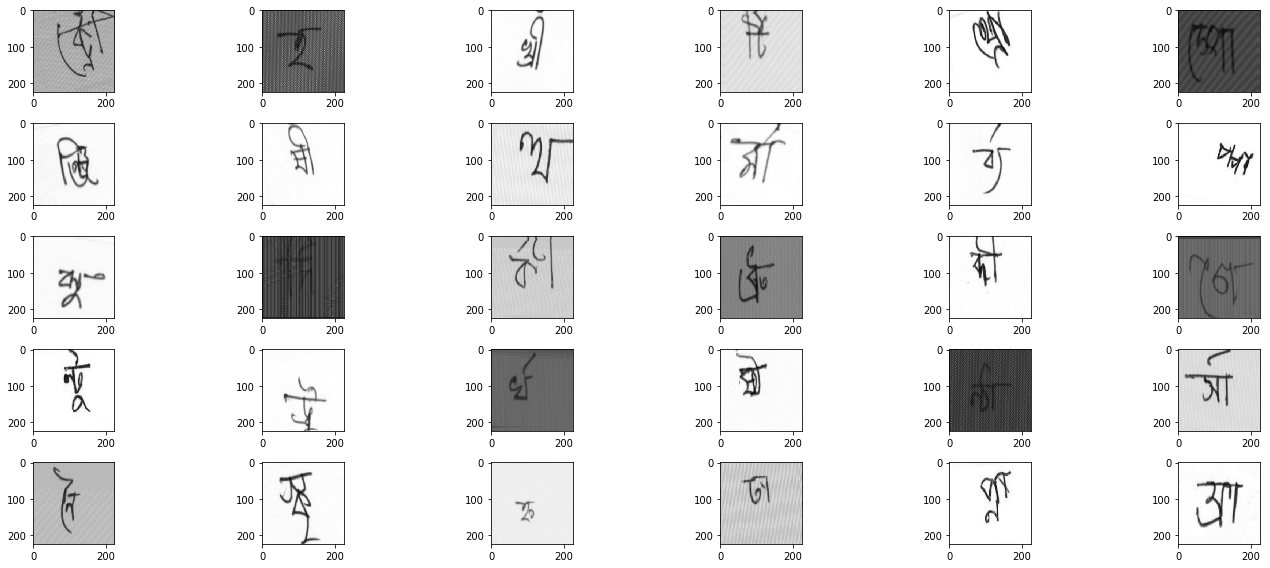

<Figure size 432x288 with 0 Axes>

In [11]:
# train_transform
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, _, _, _, _ = ds_train[i]
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image, cmap='Greys')
#     ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

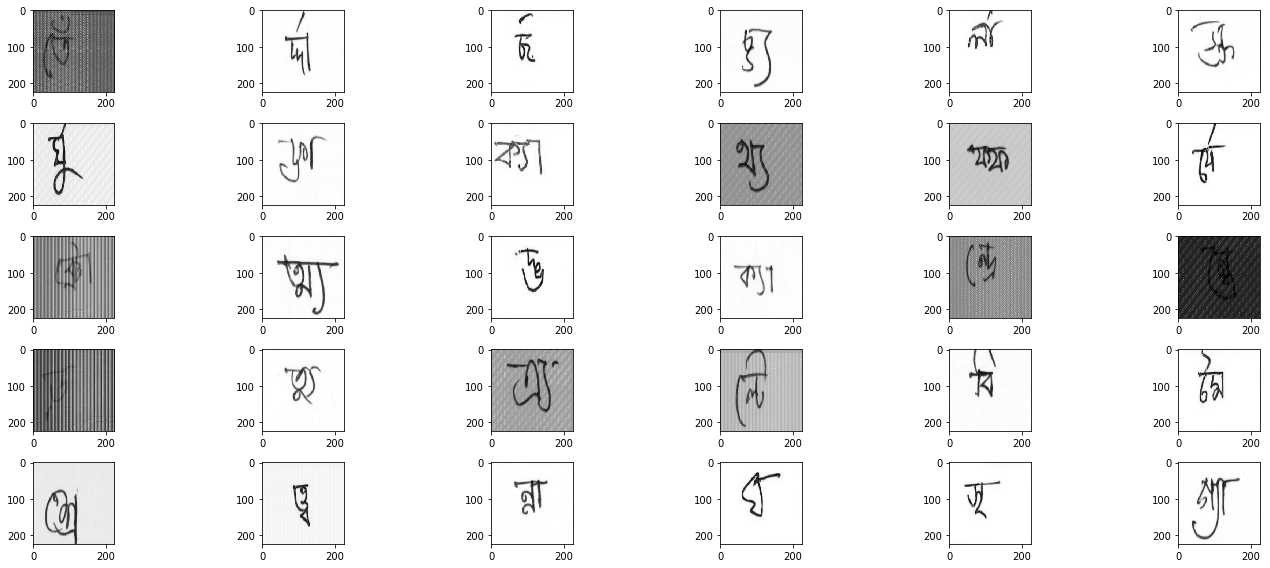

<Figure size 432x288 with 0 Axes>

In [12]:
# val_transform
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, _, _, _, _ = ds_val[i]
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image, cmap='Greys')
#     ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')